<a href="https://colab.research.google.com/github/P-Zande/quartets/blob/main/quartets2_metplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install mesa
import mesa
import numpy as np
import math
from IPython.display import Javascript
import copy
import matplotlib.pyplot as plt

In [8]:
def getCertainCard(hand, current_agent, other_agents):
    missing_cards = hand.missingCards(flat = True, exclude_unowned_groups = True)
    possible_facts = []
    for quartet_group in hand.quartet_groups:
        for knowledge in quartet_group.knowledge:
            if type(knowledge) == Fact and knowledge.agent != current_agent and knowledge.card in missing_cards and knowledge.owns == True:
                possible_facts.append(knowledge)

    if len(possible_facts) != 0:
        chosen_fact = hand.rng.choice(possible_facts)
        return chosen_fact.card, chosen_fact.agent

    return None, None

def randomStrategy(hand, current_agent, other_agents):
    missing_cards = hand.missingCards(flat = True, exclude_unowned_groups = True)
    random_card = hand.rng.choice(missing_cards)
    other_agent = hand.rng.choice(other_agents)
    return random_card, other_agent

def ownerStrategy(hand, current_agent, other_agents):
    card, agent = getCertainCard(hand, current_agent, other_agents)
    if card != None:
        return card, agent

    missing_cards = hand.missingCards(flat = True, exclude_unowned_groups = True)
    possible_facts = []

    for quartet_group in hand.quartet_groups:
        for knowledge in quartet_group.knowledge:
            if type(knowledge) == ExclusiveOr and knowledge.card in missing_cards:
                possible_facts.append(knowledge)

    if len(possible_facts) != 0:
        chosen_fact = hand.rng.choice(possible_facts)
        chosen_agent = hand.rng.choice(chosen_fact.other_agents)
        return chosen_fact.card, chosen_agent
    else:
        print("ERROR: no possible facts or exclusiveOrs found, knowledge: ")
        print(current_agent)
        print(hand.getCards())
        for quartet_group in hand.quartet_groups:
            print(quartet_group.knowledge)
        raise Exception("No possible facts found")

def defensiveStrategy(hand, current_agent, other_agents):
    card, agent = getCertainCard(hand, current_agent, other_agents)
    if card != None:
        return card, agent

    missing_cards = hand.missingCards(flat = False, exclude_unowned_groups = True)

    #Add to the possible facts list all the cards that the agent wants the most, based on how many cards it still needs from each group to complete the quartet
    cards_to_quartet = 1
    desired_cards = []
    while len(desired_cards) == 0:
        for quartet_group in missing_cards:
            if len(quartet_group) == cards_to_quartet:
                desired_cards.extend(quartet_group)
        cards_to_quartet += 1

    num_possible_owners = 2
    cards_to_ask = []
    while len(cards_to_ask) == 0:
        for quartet_group in hand.quartet_groups:
            for knowledge in quartet_group.knowledge:
                if type(knowledge) == ExclusiveOr and knowledge.card in desired_cards and len(knowledge.other_agents) == num_possible_owners:
                    cards_to_ask.append(knowledge)
        num_possible_owners += 1

    chosen_fact = hand.rng.choice(cards_to_ask)
    chosen_agent = hand.rng.choice(chosen_fact.other_agents)
    return chosen_fact.card, chosen_agent

def aggressiveStrategy(hand, current_agent, other_agents):
    card, agent = getCertainCard(hand, current_agent, other_agents)
    if card != None:
        return card, agent

    #Find the agent with the highest score and find the card that we want and has the highest chance of being owned by that agent
    missing_cards = hand.missingCards(flat = True, exclude_unowned_groups = True)

    scores = hand.model.getScores()
    # To prevent selecting yourself, set your score to -1
    scores[current_agent] = -1

    cards_to_ask = []
    while len(cards_to_ask) == 0:
        # Get highest scoring agent. In case of a tie, get a random agent of the tie
        if max(scores) == -1:
            raise Exception("Agent cannot ask any card")
        highest_agents = np.argwhere(scores == np.amax(scores)).flatten()
        highest_agent = hand.rng.choice(highest_agents)
        scores[highest_agent] = -1
        for num_items in range(2, max(3, len(other_agents))):
            for quartet_group in hand.quartet_groups:
                for knowledge in quartet_group.knowledge:
                    if (type(knowledge) == ExclusiveOr) and (highest_agent in knowledge.other_agents) and (len(knowledge.other_agents) == num_items) and (knowledge.card in missing_cards):
                        cards_to_ask.append(knowledge)
                    if (type(knowledge) == Disjunction) and (highest_agent == knowledge.other_agent) and (len(knowledge.facts) == num_items) and (knowledge.facts[0].card in missing_cards):
                        cards_to_ask.append(knowledge)

    chosen_knowledge = hand.rng.choice(cards_to_ask)
    if type(chosen_knowledge) == ExclusiveOr:
        return chosen_knowledge.card, highest_agent
    else:
        chosen_card = hand.rng.choice(chosen_knowledge.facts).card
        return chosen_card, highest_agent

In [9]:
class Fact:
    def __init__(self, agent, card, owns = True):
        self.agent = agent
        self.card = card
        self.owns = owns

    def considerFact(self, fact):
        if self.card != fact.card:
            return True
        if self.agent == fact.agent:
            # New fact is either identical to me or an update.
            if self.owns == fact.owns:
                # Identical, so this fact is not contradictory
                return True
            else:
                # Ownership changed: current fact is irrelevant
                return False
        if self.owns and fact.owns:
            # The card has a new owner; I am irrelevant
            return False
        # At this point, the new fact cannot be contradictory to me, so I stay relevant
        return True

    def getDerivableFacts(self, other_agents):
        derivable_facts = []
        if not self.owns:
            return derivable_facts
        for other_agent in other_agents:
            derivable_facts.append(Fact(other_agent, self.card, owns = False))
        return derivable_facts

    def __eq__(self, other):
        if not isinstance(other, Fact):
            return False

        return self.agent == other.agent and self.card == other.card and self.owns == other.owns

    def __repr__(self):
        return "fact_" + str(self.agent) + "_" + str(self.card) + "_" + str(self.owns)

    def __hash__(self):
        return hash((self.agent, self.card, self.owns))

class Disjunction:
    def __init__(self, other_agent, cards):
        self.facts = [Fact(other_agent, card, owns = True) for card in cards]
        self.other_agent = other_agent

    def getCards(self):
        return [fact.card for fact in self.facts]

    # Returns whether this knowledge is still relevant
    def considerFact(self, new_fact):
        # If the fact makes one element of the disjunct impossible, delete that element from cards
        # If the fact satisfies one element from the disjunct, delete the disjunct
        fact_to_remove = None
        for disjunct_fact in self.facts:
            if disjunct_fact == new_fact:
                # New fact satisfies disjuction, so delete the disjunct
                return False
            if not disjunct_fact.considerFact(new_fact):
                # If new fact makes current fact impossible, remove this fact from the facts
                fact_to_remove = disjunct_fact

        if (fact_to_remove != None):
            self.facts.remove(fact_to_remove)
        return True

    def __eq__(self, other):
        if not isinstance(other, Disjunction):
            return False

        return set(self.facts) == set(other.facts)

    def __repr__(self):
        return "disjunct_" + str(self.facts)

class ExclusiveOr:
    def __init__(self, other_agents, card):
        self.other_agents = copy.copy(other_agents)
        self.card = card

    # Returns whether this knowledge is still relevant
    def considerFact(self, fact):
        if self.card != fact.card:
            return True
        if fact.owns:
            # delete the ExclusiveOr
            return False
        else:
            try:
                self.other_agents.remove(fact.agent)
            except ValueError:
                pass
        return True

    def __eq__(self, other):
        if not isinstance(other, ExclusiveOr):
            return False

        return self.other_agents == other.other_agents and self.card == other.card

    def __repr__(self):
        return "exclusiveor_" + str(self.other_agents) + "_" + str(self.card)



In [44]:
def flatten(l):
    return [item for sublist in l for item in sublist]

class Hand:
    def __init__(self, model, agent, other_agents, rng):
        self.model = model
        self.agent = agent
        self.other_agents = other_agents
        self.quartet_groups = [QuartetGroup(quartet_set.group_name, quartet_set.card_names, agent, other_agents)
                              for quartet_set in self.model.quartet_sets]
        self.rng = rng

    def getCards(self, flat = False):
        cards = [quarted_group.getCards() for quarted_group in self.quartet_groups]
        if flat:
            cards = flatten(cards)
        return cards

    def addCard(self, new_card):
        for quartet_group in self.quartet_groups:
            if quartet_group.group_name == new_card.group_name:
                quartet_group.addCard(new_card)
                return quartet_group.isComplete()

    def missingCards(self, flat = False, exclude_unowned_groups = False):
        missing_cards = [group.missingCards() for group in self.quartet_groups]
        if exclude_unowned_groups:
            new_missing_cards = []
            for missing_cards_group in missing_cards:
                if len(missing_cards_group) != 4:
                    new_missing_cards.append(missing_cards_group)
            missing_cards = new_missing_cards

        if flat:
            missing_cards = flatten(missing_cards)
        return missing_cards

    def getGroup(self, group_name):
        for quartet_group in self.quartet_groups:
            if quartet_group.group_name == group_name:
                return quartet_group

    def getCard(self, asked_card):
        quartet_group = self.getGroup(asked_card.group_name)
        for card in quartet_group.cards:
            if card.card_name == asked_card.card_name:
                return card

    def giveCard(self, asked_card):
        card = self.getCard(asked_card)
        if card.owned:
            card.owned = False
            return True
        return False

    def updateAgentHasGroup(self, other_agent_id, group_name, excluded_card):
        quartet_group = self.getGroup(group_name)
        quartet_group.updateAgentHasGroup(other_agent_id, excluded_card)

    def updateAgentHasCard(self, agent_id, card):
        quartet_group = self.getGroup(card.group_name)
        quartet_group.updateAgentHasCard(agent_id, card)

    def updateAgentDoesNotHaveCard(self, agent_id, card):
        quartet_group = self.getGroup(card.group_name)
        quartet_group.updateAgentDoesNotHaveCard(agent_id, card)

class QuartetGroup:
    def __init__(self, group_name, card_names, agent = -1, other_agents = []):
        self.group_name = group_name
        self.card_names = card_names
        self.agent = agent
        self.other_agents = other_agents
        self.cards = [QuartetCard(group_name, card_name, self) for card_name in card_names]
        self.knowledge = []
        self.print_logic = False #Makes the run way faster if set to false, set to true if the logic is necessary to show

        for card in self.cards:
            card_knowledge = ExclusiveOr(other_agents, card)
            self.knowledge.append(card_knowledge)
            self.knowledge.append(Fact(self.agent, card, owns = False))
            # self.potential_owners.append(-1)

    def getCardObject(self, asked_card):
        for card in self.cards:
            if asked_card == card:
                return card

    def addCard(self, new_card):
        for card in self.cards:
            if new_card == card:
                card.owned = True
                new_fact = Fact(self.agent, card)
                self.addFact(new_fact)

    def missingCards(self):
        current_cards = self.getCards()
        return [x for x in self.cards if x not in current_cards]

    def getCards(self):
        return [x for x in self.cards if x.owned]

    def isComplete(self):
        return np.all([x.owned for x in self.cards])

    def addFact(self, fact):
        if fact in self.knowledge:
            return
        updated_knowledge = []
        # Update current knowledge base
        for knowledge in self.knowledge:
            keep_knowledge = knowledge.considerFact(fact)
            if keep_knowledge:
                updated_knowledge.append(knowledge)

        # Add the fact
        updated_knowledge.append(fact)
        self.knowledge = updated_knowledge
        self.collapseExclusiveOrs()
        self.collapseDisjunctions()

        # If we learned that an agent now owns a certain card, also add the facts that the other agents do not own the card
        all_other_agents = self.other_agents + [self.agent]
        all_other_agents.remove(fact.agent)
        derivable_facts = fact.getDerivableFacts(all_other_agents)
        for derivable_fact in derivable_facts:
            if self.print_logic:
                print("From fact ", fact, " I (agent ", self.agent, ") derived ", derivable_fact, sep = '')
            self.addFact(derivable_fact)


    def collapseExclusiveOrs(self):
        collapsing_ors = []
        for knowledge in self.knowledge:
            if type(knowledge) == ExclusiveOr:
                if (len(knowledge.other_agents)) == 1:

                    collapsing_ors.append(copy.copy(knowledge))
        new_facts = []
        for collapsing_or in collapsing_ors:
            new_facts.append(Fact(collapsing_or.other_agents[0], collapsing_or.card, owns = True))
            if self.print_logic:
                print("From collapsing or ", collapsing_or, " I (agent ", self.agent, ") got new fact ", new_facts[-1], sep = '')
            self.knowledge.remove(collapsing_or)
        for fact in new_facts:
            self.addFact(fact)

    def collapseDisjunctions(self):
        collapsing_disjunctions = []
        for knowledge in self.knowledge:
            if type(knowledge) == Disjunction:
                if (len(knowledge.facts)) == 1:
                    collapsing_disjunctions.append(copy.copy(knowledge))
        new_facts = []
        for collapsing_disjunction in collapsing_disjunctions:
            new_facts.append(collapsing_disjunction.facts[0])
            if self.print_logic:
                print("From collapsing disjunction ", collapsing_disjunction, " I (agent ", self.agent, ") got new fact ", new_facts[-1], sep = '')
            self.knowledge.remove(collapsing_disjunction)
        for fact in new_facts:
            self.addFact(fact)

    def updateAgentHasGroup(self, other_agent, excluded_card):
        if excluded_card != None:
            if self.print_logic:
                print("From ask PA I (agent ", self.agent, ") got fact ", Fact(other_agent, excluded_card, owns = False), sep = '')
            self.addFact(Fact(other_agent, excluded_card, owns = False))
        # If there is already a disjunction for this agent, no extra info is learned
        for knowledge in self.knowledge:
            if type(knowledge) == Disjunction:
                if knowledge.other_agent == other_agent:
                    return

        new_knowledge = Disjunction(other_agent, self.cards)
        save_disjunction = True
        for knowledge in self.knowledge:
            if type(knowledge) == Fact:
                save_disjunction &= new_knowledge.considerFact(knowledge)
        # If the disjunction is already satisfied, no need to save it
        if save_disjunction:
            self.knowledge.append(new_knowledge)
        # The new disjunction could already collapse
        self.collapseDisjunctions()
        if self.print_logic:
            print("As agent", self.agent, "I have this knowledge:", self.knowledge)

    def updateAgentHasCard(self, agent_id, card):
        card_object = self.getCardObject(card)
        if self.print_logic:
          print("From the 'has card' PA I (agent ", self.agent, ") got fact ", Fact(agent_id, card_object, owns = True), sep = '')
        self.addFact(Fact(agent_id, card_object, owns = True))

    def updateAgentDoesNotHaveCard(self, agent_id, card):
        card_object = self.getCardObject(card)
        if self.print_logic:
            print("From the 'does not have card' PA I (agent ", self.agent, ") got fact ", Fact(agent_id, card_object, owns = False), sep = '')
        self.addFact(Fact(agent_id, card_object, owns = False))

    def __repr__(self):
        return str([card for card in self.cards])

class QuartetCard:
    def __init__(self, group_name, card_name, quartet_group, owned = False):
        self.group_name = group_name
        self.card_name = card_name
        self.quartet_group = quartet_group
        self.owned = owned

    def __eq__(self, other):
        if not isinstance(other, QuartetCard):
            return NotImplemented

        return self.group_name == other.group_name and self.card_name == other.card_name

    def __repr__(self):
        return self.group_name + "_" + self.card_name

    def __hash__(self):
        return hash((self.group_name, self.card_name))

class QuartetAgent(mesa.Agent):

    def __init__(self, unique_id, model, strategy, rng):
        super().__init__(unique_id, model)
        self.other_agents = [i for i in range(self.model.num_agents) if i != self.unique_id]
        self.hand = Hand(model, unique_id, self.other_agents, rng)
        self.score = 0
        self.strategy = strategy


    def step(self):
        if not self.model.running:
            return
        # print("It is agent " + str(self.unique_id) + "'s turn.")
        # print("I currently have these cards:")
        # print(self.hand.getCards())
        # print("I currently do not have these cards:")
        # print(self.hand.missingCards())

        missing_cards = self.hand.missingCards(flat = True, exclude_unowned_groups = True)
        if len(missing_cards) == 0:
            self.model.skipTurn(self.unique_id)
            return

        asked_card, other_agent = self.strategy(self.hand, self.unique_id, self.other_agents)

        got_card = self.model.askForCard(self, other_agent, asked_card)
        if got_card:
            self.addCard(asked_card)
            self.step()

    def addCard(self, new_card):
        has_complete_set = self.hand.addCard(new_card)
        if has_complete_set:
            self.score += 1
            self.model.announceCompleteGroup(self.unique_id, new_card.group_name)

    def giveCard(self, card):
        return self.hand.giveCard(card)

    def updateAgentHasGroup(self, other_agent_id, group_name, excluded_card):
        self.hand.updateAgentHasGroup(other_agent_id, group_name, excluded_card)

    def updateAgentHasCard(self, agent_id, card):
        self.hand.updateAgentHasCard(agent_id, card)

    def updateAgentDoesNotHaveCard(self, asked_agent_id, card):
        self.hand.updateAgentDoesNotHaveCard(asked_agent_id, card)



class QuartetModel(mesa.Model):

    def __init__(self, N, strategies, rng = np.random.default_rng()):
        self.running = True
        self.num_agents = N
        self.strategies = strategies
        self.schedule = mesa.time.BaseScheduler(self)
        self.quartet_sets = [QuartetGroup('a', ['1', '2', '3', '4']),
                             QuartetGroup('b', ['1', '2', '3', '4']),
                             QuartetGroup('c', ['1', '2', '3', '4']),
                             QuartetGroup('d', ['1', '2', '3', '4']),
                             QuartetGroup('e', ['1', '2', '3', '4']),
                             QuartetGroup('f', ['1', '2', '3', '4']),
                             QuartetGroup('g', ['1', '2', '3', '4']),
                             QuartetGroup('h', ['1', '2', '3', '4'])]
        self.completed_sets = 0
        self.agent_can_ask_owned_card = False
        self.print_announcements = False
        self.rng = rng
        # Create agents
        for i in range(self.num_agents):
            a = QuartetAgent(i, self, self.strategies[i], rng)
            self.schedule.add(a)

        all_cards = []
        for quartet_set in self.quartet_sets:
            for quartet_card in quartet_set.cards:
                all_cards.append(quartet_card)
        self.rng.shuffle(all_cards)

        cards_per_agent = math.ceil(len(all_cards) / self.num_agents)
        for i in range(cards_per_agent):
            for agent in self.schedule.agents:
                if len(all_cards) != 0:
                    current_card = all_cards.pop()
                    agent.addCard(current_card)

    def step(self):
        """Advance the model by one step."""
        # for agent in self.schedule.agents:
            # print(agent.unique_id)
            # print(agent.hand.getCards())
            # for quartet_group in agent.hand.quartet_groups:
            #     print(quartet_group.knowledge)
        self.schedule.step()

    def askForCard(self, asking_agent, asked_agent_id, card):
        asking_agent_id = asking_agent.unique_id
        if self.print_announcements:
            print("PA: Agent", asking_agent_id, "asks agent", asked_agent_id, "for card", card)
        asked_agent_object = self.schedule.agents[asked_agent_id]
        self.announceAgentHasGroup(asking_agent, card)
        has_card = asked_agent_object.giveCard(card)
        if has_card:
            if self.print_announcements:
                print("PA: Agent", asked_agent_id, "had the card and gave it to", asking_agent_id)
            # First, consider that the asked agent had the card
            self.announceAgentHasCard(asked_agent_id, card)
            # Now, update that the asking agent received the card
            self.announceAgentHasCard(asking_agent_id, card)
        else:
            if self.print_announcements:
                print("PA: Agent", asked_agent_id, "did not have the card.")
            self.announceAgentDoesNotHaveCard(asked_agent_id, card)
        if self.print_announcements:
            print("")
        return has_card

    def announceAgentHasGroup(self, asking_agent, card):
        # The asking agent has complete knowledge over its cards, so we can skip this
        # This is always a successful announcement
        group_name = card.group_name
        other_agents = [agent for agent in self.schedule.agents if agent != asking_agent]
        excluded_card = None
        if not self.agent_can_ask_owned_card:
            excluded_card = card
        for agent in other_agents:
            agent.updateAgentHasGroup(asking_agent.unique_id, group_name, excluded_card)

    def announceAgentHasCard(self, asking_agent_id, card):
        other_agents = [agent for agent in self.schedule.agents if agent != asking_agent_id]
        for agent in other_agents:
            agent.updateAgentHasCard(asking_agent_id, card)

    def announceAgentDoesNotHaveCard(self, asked_agent_id, card):
        other_agents = [agent for agent in self.schedule.agents if agent != asked_agent_id]
        for agent in other_agents:
            agent.updateAgentDoesNotHaveCard(asked_agent_id, card)

    def announceCompleteGroup(self, agent, group_name):
        if self.print_announcements:
            print("PA: Agent", agent, "has completed the set", group_name)
        self.completed_sets += 1
        if len(self.quartet_sets) == self.completed_sets:
            self.finishGame()

    def skipTurn(self, agent):
        if self.print_announcements:
            print("PA: Agent", agent, "cannot ask for any card and skips this turn.")

    def finishGame(self):
        self.running = False
        if self.print_announcements:
            print("----------------------------------------------------------------------------")
            print("The game is finished! Here are the scores:")
            for agent in self.schedule.agents:
                print("Agent", agent.unique_id, "has score", agent.score)

    def getScores(self):
        scores = []
        for agent in self.schedule.agents:
            scores.append(agent.score)
        return scores

    def getWinners(self):
        scores = self.getScores()
        return np.argwhere(scores == np.amax(scores)).flatten()

In [49]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

strategyNames = [randomStrategy, ownerStrategy, defensiveStrategy, aggressiveStrategy]

strategies = [aggressiveStrategy, aggressiveStrategy, aggressiveStrategy]
num_agents = 3
num_runs = 1000
rng = np.random.default_rng(12345)

a = 0
for i in range(a):
    a += rng.random()

total_scores = [0] * num_agents
total_wins = [0] * num_agents
plot_scores = []
plot_wins = []
for i in range(num_runs):
    model = QuartetModel(num_agents, strategies, rng)
    model.run_model()
    total_scores = np.add(total_scores, model.getScores())
    plot_scores.append(total_scores)
    winners = model.getWinners()
    for winner in winners:
        total_wins[winner] += (1 / len(winners))
    plot_wins.append(copy.copy(total_wins))

print(total_scores)
print(total_wins)

<IPython.core.display.Javascript object>

[2910 2705 2385]
[410.5, 330.0, 259.5]


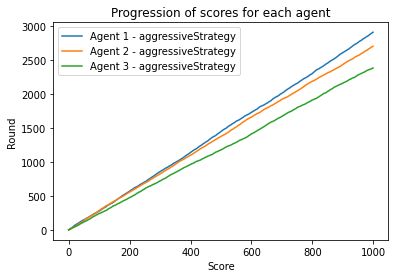

In [50]:
# Plot each agent's line
for agent in range(num_agents):
    line_data = [d[agent] for d in plot_scores]  # Extract data for the current agent
    x = np.arange(len(line_data))  # Generate x values
    y = line_data  # Use the line data as y values
    plt.plot(x, y, label=f'Agent {agent+1} - {strategies[agent].__name__}')  # Plot the line

plt.xlabel('Score')
plt.ylabel('Round')
plt.title('Progression of scores for each agent')
plt.legend()

plt.show()


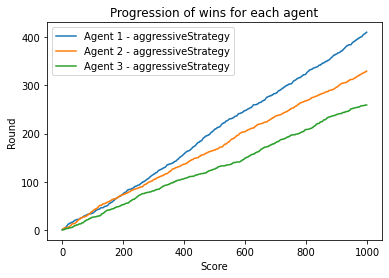

In [51]:
# Plot each agent's line
for agent in range(num_agents):
    line_data = [d[agent] for d in plot_wins]  # Extract data for the current agent
    x = np.arange(len(line_data))  # Generate x values
    y = line_data  # Use the line data as y values
    plt.plot(x, y, label=f'Agent {agent+1} - {strategies[agent].__name__}')  # Plot the line

plt.xlabel('Score')
plt.ylabel('Round')
plt.title('Progression of wins for each agent')
plt.legend()

plt.show()